## Evaluate the Prodigy results

In [2]:
import json
import random

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
cd ..

/Users/gallaghe/Code/nutrition-labels


In [4]:
from nutrition_labels.utils import pretty_confusion_matrix

In [6]:
def read_jsonl(file_dir):

    data = []
    with open(file_dir, 'r') as json_file:
        for json_str in list(json_file):
            data.append(json.loads(json_str))

    return data

In [7]:
def get_prodigy_x_y(data, cat2bin):
    """
    Get the X and y for the model from a Prodigy dataset
    Use cat2bin to convert categories used for tagging into 0 and 1
    If the answer is reject then use the other tag, 
    e.g. reject 'Not tech grant' means accept 'tech grant'
    """
    data = [eg for eg in data if eg["answer"] != "ignore"]
    X = [annotation['text'] for annotation in data]
    y = []
    session_name = [annotation['session_name'] for annotation in data]
    for annotation in data:
        label = cat2bin[annotation['label']]
        if annotation['answer']=='accept':
            y.append(label)
        else:
            # We've already filtered about 'ignore'
            # If label=1, append 0 
            # if label=0, append 1
            y.append(abs(label - 1))

    return X, y, session_name

In [8]:
cat2bin = {'Not tech grant': 0, 'Tech grant': 1}

In [9]:
# Load the original test data
test_data = read_jsonl('data/prodigy/existing_test_data.jsonl')

test_X = [annotation['text'] for annotation in test_data]
test_y = [cat2bin[annotation['label']] for annotation in test_data]

In [33]:
# Load the new training data
train_data = read_jsonl('data/prodigy/tech_grants_2/tech_grants_2.jsonl')

In [34]:
# Shuffle up the old training data since it wasn't suppose to be in any particular order
# but it may be that the latter data was skewed to 'not tech' when I was trying to 
# get more of it
original_indices = [i for i, t in enumerate(train_data) if t['session_name'] == 'Originally labelled training data']
prodigy_indices = [i for i, t in enumerate(train_data) if t['session_name'] != 'Originally labelled training data']
random.seed(42)
random.shuffle(original_indices)
indices_order = original_indices + prodigy_indices
train_data = [train_data[i] for i in indices_order]

In [35]:
train_X, train_y, train_session_name = get_prodigy_x_y(train_data, cat2bin)

In [36]:
len(train_data)

891

In [37]:
from collections import Counter
Counter(train_session_name)

Counter({'Originally labelled training data': 520,
         'Low scoring tech grant predictions': 100,
         'High scoring tech grant predictions': 200})

In [38]:
def train_model(train_X, train_y, test_X, test_y, average_type):
    # Train vectorizer
    vectorizer = TfidfVectorizer(
        analyzer='word',
        token_pattern=r'(?u)\b\w+\b',
        ngram_range=(1, 2)
        )
    
    train_X_vec = vectorizer.fit_transform(train_X)
    test_X_vec = vectorizer.transform(test_X)

    # Train model
    model = LogisticRegression(max_iter=1000)
    model = model.fit(train_X_vec, train_y)

    train_y_pred = model.predict(train_X_vec)
    test_y_pred = model.predict(test_X_vec)
    
    return {
        'train_f1': f1_score(train_y, train_y_pred, average=average_type),
        'train_precision': precision_score(train_y, train_y_pred, average=average_type),
        'train_recall': recall_score(train_y, train_y_pred, average=average_type),
        'test_f1': f1_score(test_y, test_y_pred, average=average_type),
        'test_precision': precision_score(test_y, test_y_pred, average=average_type),
        'test_recall': recall_score(test_y, test_y_pred, average=average_type),
        'test_prop_labelled_not_tech': (len(test_y_pred)-sum(test_y_pred))/len(test_y_pred)
    }

## Plot the test scores (with same test data) as more data is added
and add a line where we started using Prodigy

In [39]:
average_type='binary'
train_info = []
for length_batch in np.linspace(100, len(train_X), 100).astype(int):
    train_X_batch = train_X[0:length_batch]
    train_y_batch = train_y[0:length_batch]
    
    scores = train_model(train_X_batch, train_y_batch, test_X, test_y, average_type)
    scores['length_batch'] = length_batch
    train_info.append(scores)

In [40]:
train_info_df = pd.DataFrame(train_info)

In [41]:
first_low_score_prodigy = len(train_session_name)
first_high_score_prodigy = len(train_session_name)
for i, t in enumerate(train_session_name):
    if t=='Low scoring tech grant predictions':
        first_low_score_prodigy = min(i, first_low_score_prodigy)
    if t=='High scoring tech grant predictions':
        first_high_score_prodigy = min(i, first_high_score_prodigy)

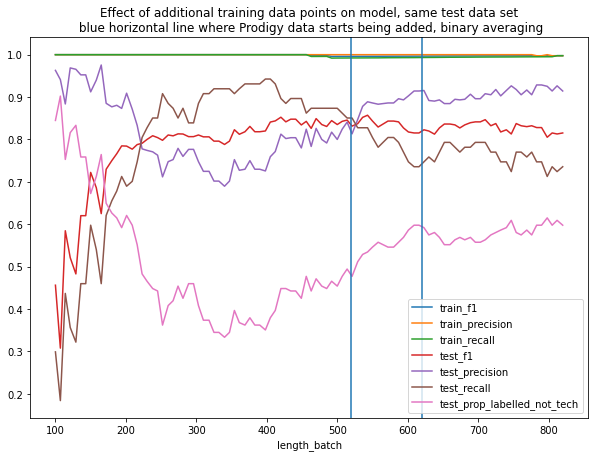

In [42]:
train_info_df.plot(x='length_batch', figsize=(10,7),
                  title=f'Effect of additional training data points on model, same test data set\n blue horizontal line where Prodigy data starts being added, {average_type} averaging');
plt.axvline(first_low_score_prodigy);
plt.axvline(first_high_score_prodigy);

## Do the train/test split each time

In [43]:
test_session_name = [annotation['session_name'] for annotation in test_data]

In [44]:
all_X = test_X + train_X
all_y = test_y + train_y
all_session_name = test_session_name + train_session_name

In [45]:
len(all_session_name)

994

In [46]:
average_type = 'binary'
train_info_2 = []
for length_batch in np.linspace(100, len(all_X), 50).astype(int):
    all_X_batch = all_X[0:length_batch]
    all_y_batch = all_y[0:length_batch]
    
    all_scores = []
    for i in range(0,10):
        # Test/train split with different random seeds
        train_X_batch, test_X_batch, train_y_batch, test_y_batch = train_test_split(
            all_X_batch, all_y_batch, test_size=0.25, random_state=i)
        scores = train_model(train_X_batch, train_y_batch, test_X_batch, test_y_batch, average_type)
        all_scores.append(scores)
    # Calculate average of 10 scores for this length batch
    df = pd.DataFrame(all_scores)
    average_scores = dict(df.mean())
    average_scores['length_batch'] = length_batch
    train_info_2.append(average_scores)

/Users/gallaghe/Code/nutrition-labels/build/virtualenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gallaghe/Code/nutrition-labels/build/virtualenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
train_info_2_df = pd.DataFrame(train_info_2)

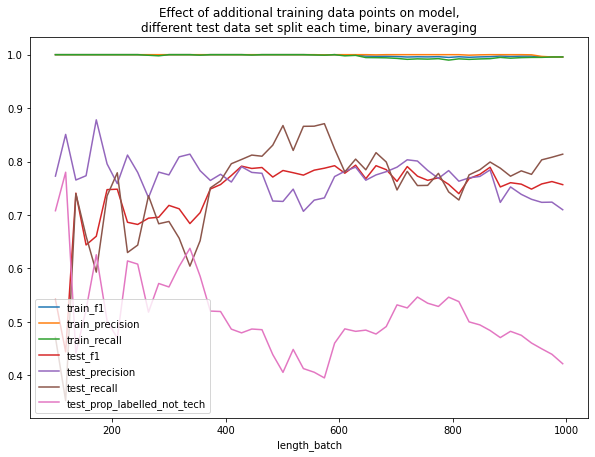

In [48]:
train_info_2_df.plot(x='length_batch', figsize=(10,7),
                    title=f'Effect of additional training data points on model,\ndifferent test data set split each time, {average_type} averaging');

## Plot the increase only using Prodigy data
Start with 100 original data points, plot trajectory of additional prodigy vs additional original

In [49]:
orig_training_data = [t for t in train_data if t['session_name']=='Originally labelled training data']
orig_train_X, orig_train_y, _ = get_prodigy_x_y(orig_training_data, cat2bin)

In [50]:
starter_n = 200
starter_orig_train_X = orig_train_X[0:starter_n]
starter_orig_train_y = orig_train_y[0:starter_n]

rest_orig_train_X = orig_train_X[starter_n:]
rest_orig_train_y = orig_train_y[starter_n:]

### All Prodigy tags in order

In [51]:
prod_training_data = [t for t in train_data if t['session_name']!='Originally labelled training data']
prod_train_X, prod_train_y, _ = get_prodigy_x_y(prod_training_data, cat2bin)

In [103]:
starter_n = 200

average_type = 'binary'

prod_orig_train_info = []
for length_batch in np.linspace(0, len(prod_train_X), 20).astype(int):
    all_scores = []
    for i in range(0,10):
        # Pick a random selection of original starting data
        random.seed(i)
        orig_train_zip = list(zip(orig_train_X, orig_train_y))
        random.shuffle(orig_train_zip)
        starter_orig_train_X = [x[0] for x in orig_train_zip[0:starter_n]]
        starter_orig_train_y = [x[1] for x in orig_train_zip[0:starter_n]]
        rest_orig_train_X = [x[0] for x in orig_train_zip[starter_n:]]
        rest_orig_train_y = [x[1] for x in orig_train_zip[starter_n:]]

        # Train
        prod_train_X_batch = starter_orig_train_X + prod_train_X[0:length_batch]
        prod_train_y_batch = starter_orig_train_y + prod_train_y[0:length_batch]
        prod_scores = train_model(prod_train_X_batch, prod_train_y_batch, test_X, test_y, average_type)

        orig_train_X_batch = starter_orig_train_X + rest_orig_train_X[0:length_batch]
        orig_train_y_batch = starter_orig_train_y + rest_orig_train_y[0:length_batch]
        orig_scores = train_model(orig_train_X_batch, orig_train_y_batch, test_X, test_y, average_type)

        scores = {'Prodigy_'+k:v for k, v in prod_scores.items()}
        scores.update({'Original_'+k:v for k, v in orig_scores.items()})
        all_scores.append(scores)
#     Calculate average of 10 scores for this length batch
    df = pd.DataFrame(all_scores)
    average_scores = dict(df.mean())
    average_scores['length_batch'] = len(starter_orig_train_X) + length_batch
    prod_orig_train_info.append(average_scores)

In [104]:
prod_orig_train_info_df = pd.DataFrame(prod_orig_train_info)

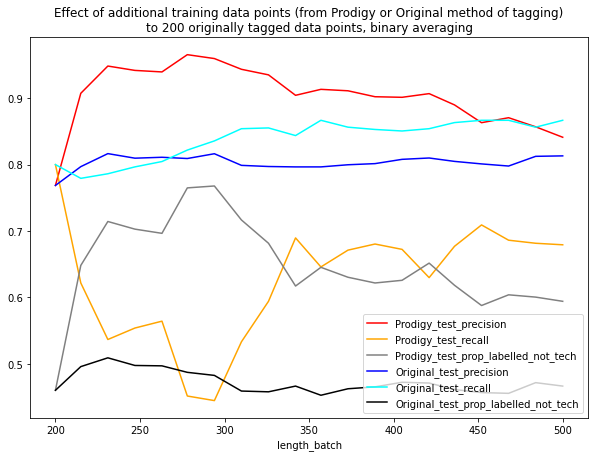

In [105]:
prod_orig_train_info_df[[
    'length_batch', 'Prodigy_test_precision', 'Prodigy_test_recall', 'Prodigy_test_prop_labelled_not_tech',
    'Original_test_precision', 'Original_test_recall', 'Original_test_prop_labelled_not_tech'
]].plot(x='length_batch', figsize=(10,7), color=['red','orange','grey','blue','cyan','black'],
        title=f'Effect of additional training data points (from Prodigy or Original method of tagging)\nto {starter_n} originally tagged data points, {average_type} averaging');

### Just high Prodigy tags

In [106]:
prod_high_training_data = [t for t in train_data if t['session_name']=='High scoring tech grant predictions']
prod_high_train_X, prod_high_train_y, _ = get_prodigy_x_y(prod_high_training_data, cat2bin)

In [107]:
prod_low_training_data = [t for t in train_data if t['session_name']=='Low scoring tech grant predictions']
prod_low_train_X, prod_low_train_y, _ = get_prodigy_x_y(prod_low_training_data, cat2bin)

In [108]:
average_type = 'binary'

prod_sep_orig_train_info = []
for length_batch in np.linspace(0, len(prod_high_train_X), 20).astype(int):
    
    all_scores = []
    for i in range(0,10):
        # Pick a random selection of original starting data
        random.seed(i)
        orig_train_zip = list(zip(orig_train_X, orig_train_y))
        random.shuffle(orig_train_zip)
        starter_orig_train_X = [x[0] for x in orig_train_zip[0:starter_n]]
        starter_orig_train_y = [x[1] for x in orig_train_zip[0:starter_n]]
        rest_orig_train_X = [x[0] for x in orig_train_zip[starter_n:]]
        rest_orig_train_y = [x[1] for x in orig_train_zip[starter_n:]]
   
        prod_high_train_X_batch = starter_orig_train_X + prod_high_train_X[0:length_batch]
        prod_high_train_y_batch = starter_orig_train_y + prod_high_train_y[0:length_batch]
        prod_high_scores = train_model(prod_high_train_X_batch, prod_high_train_y_batch, test_X, test_y, average_type)

        prod_low_train_X_batch = starter_orig_train_X + prod_low_train_X[0:length_batch]
        prod_low_train_y_batch = starter_orig_train_y + prod_low_train_y[0:length_batch]
        prod_low_scores = train_model(prod_low_train_X_batch, prod_low_train_y_batch, test_X, test_y, average_type)

        orig_train_X_batch = starter_orig_train_X + rest_orig_train_X[0:length_batch]
        orig_train_y_batch = starter_orig_train_y + rest_orig_train_y[0:length_batch]
        orig_scores = train_model(orig_train_X_batch, orig_train_y_batch, test_X, test_y, average_type)

        scores = {'Prodigy_High_'+k:v for k, v in prod_high_scores.items()}
        scores.update({'Prodigy_Low_'+k:v for k, v in prod_low_scores.items()})
        scores.update({'Original_'+k:v for k, v in orig_scores.items()})

        all_scores.append(scores)
#     Calculate average of 10 scores for this length batch
    df = pd.DataFrame(all_scores)
    average_scores = dict(df.mean())
    average_scores['length_batch'] = len(starter_orig_train_X) + length_batch
    
    prod_sep_orig_train_info.append(average_scores)

In [109]:
prod_sep_orig_train_info_df = pd.DataFrame(prod_sep_orig_train_info)

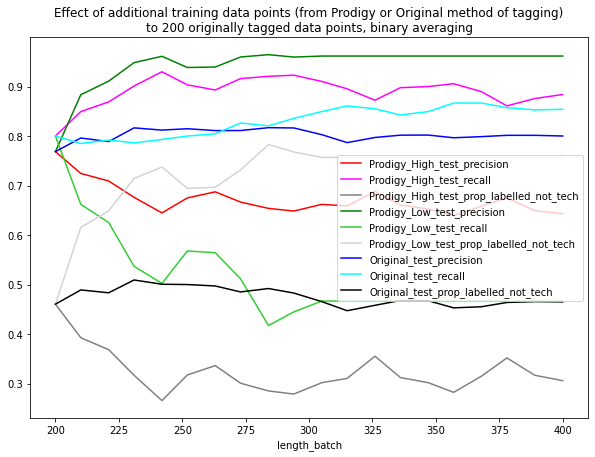

In [110]:
prod_sep_orig_train_info_df[[
    'length_batch',
    'Prodigy_High_test_precision', 'Prodigy_High_test_recall', 'Prodigy_High_test_prop_labelled_not_tech',
    'Prodigy_Low_test_precision', 'Prodigy_Low_test_recall', 'Prodigy_Low_test_prop_labelled_not_tech',
    'Original_test_precision', 'Original_test_recall', 'Original_test_prop_labelled_not_tech'
]].plot(x='length_batch', figsize=(10,7), color=[
    'red','magenta','grey',
    'green','limegreen','lightgrey',
    'blue','cyan','black'],
        title=f'Effect of additional training data points (from Prodigy or Original method of tagging)\nto {starter_n} originally tagged data points, {average_type} averaging');

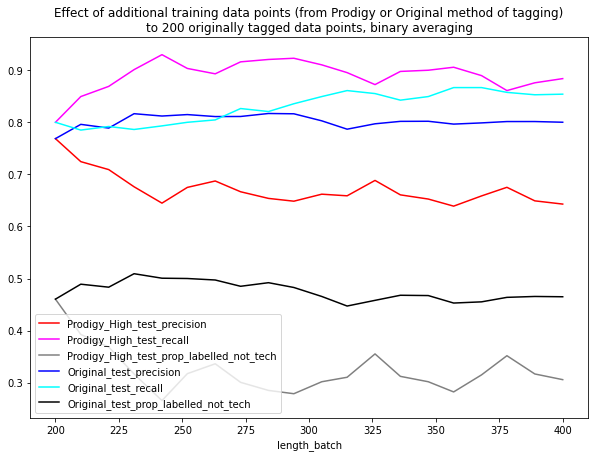

In [111]:
prod_sep_orig_train_info_df[[
    'length_batch',
    'Prodigy_High_test_precision', 'Prodigy_High_test_recall', 'Prodigy_High_test_prop_labelled_not_tech',
    'Original_test_precision', 'Original_test_recall', 'Original_test_prop_labelled_not_tech'
]].plot(x='length_batch', figsize=(10,7), color=[
    'red','magenta','grey',
    'blue','cyan','black'],
        title=f'Effect of additional training data points (from Prodigy or Original method of tagging)\nto {starter_n} originally tagged data points, {average_type} averaging');

In [5]:
# # I had to do this since I hadn't included the session name integration before
# # having tagged 100 data points, so this is a ONE-OFF hack way to update
# # the dataset
# existing_training_data=[]
# with open('data/prodigy/existing_training_data.jsonl', 'r') as json_file:
#     for json_str in list(json_file):
#         data = json.loads(json_str)
#         existing_training_data.append(data)
        
# # Load the new training data
# new_training_data=[]
# with open('data/prodigy/tech_grants_2/tech_grants_2_backup3.jsonl', 'r') as json_file:
#     for json_str in list(json_file):
#         data = json.loads(json_str)
#         new_training_data.append(data)
        
# merged_df = pd.DataFrame(new_training_data).merge(
#     pd.DataFrame(existing_training_data)[['id','session_name']],
#     on='id',
#     how = 'left')

# merged_df['session_name_x'].update(merged_df.pop('session_name_y'))

# merged_df['session_name'] = ["Low scoring tech grant predictions" if pd.isnull(m) else m for m in merged_df['session_name_x'].tolist()]

# merged_df_dict = merged_df.to_dict(orient='records')

# with open('data/prodigy/tech_grants_2/tech_grants_2.jsonl', 'w') as json_file:
#     for entry in merged_df_dict:
#         json.dump(entry, json_file)
#         json_file.write('\n')